In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import random
from torch.utils.data import DataLoader, Dataset
import tqdm
import re
from transformers import AutoModelForSequenceClassification, AutoTokenizer, logging

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def preprocess_code(code):
    code = re.sub('\/\/.+', '', code)
    code = re.sub('#include.+', '', code)
    code = re.sub('#define ', '', code)
    code = re.sub('using namespace.+', '', code)
    code = re.sub('using ', '', code)
    code = re.sub('\/\*.*\*\/', '', code, flags=re.DOTALL)
    code = re.sub('\\\n+', '', code)
    code = re.sub('\n+', '', code)
    code = re.sub(' +', ' ', code)
    code = re.sub('\t+', ' ', code)
    return code

class TrainDataset(Dataset):
    def __init__(self, seed):
        super(type(self), self).__init__()
        self.idx = np.arange(500*500)
        np.random.shuffle(self.idx)
        self.ref = np.random.randint(0,499*499,500*500)
        print(f'seed {seed} idx {self.idx[0]}')

    def __getitem__(self, i):
        prob = (self.idx[i] // 500) + 1
        num = (self.idx[i] % 500) + 1

        with open(f'train_code/problem{prob:03d}/problem{prob:03d}_{num}.cpp') as fs:
            code = ''.join(fs.readlines())
            code = preprocess_code(code)

        num += self.ref[i] % 499 + 1
        num = num - 500 if num > 500 else num
        with open(f'train_code/problem{prob:03d}/problem{prob:03d}_{num}.cpp') as fs:
            code_same = ''.join(fs.readlines())
            code_same = preprocess_code(code_same)

        prob += self.ref[i] // 499 + 1
        prob = prob - 500 if prob > 500 else prob
        with open(f'train_code/problem{prob:03d}/problem{prob:03d}_{num}.cpp') as fs:
            code_diff = ''.join(fs.readlines())
            code_diff = preprocess_code(code_diff)

        return code, code_same, code_diff

    def __len__(self):
        return 500*500

In [3]:
def get_logits(model_path:str):
    torch.cuda.empty_cache()
    pt_path = model_path.split('/')[-1] + '.pt'

    tokenizer = AutoTokenizer.from_pretrained(model_path, truncation_side='left')

    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    checkpoint = torch.load(pt_path)
    model.load_state_dict(checkpoint['model'])

    model.eval()
    with torch.no_grad():
        tq = tqdm.tqdm(dataloader)
        logits = []
        for i, (code_org, code_same, code_diff) in enumerate(tq):
            if i == n_train_iter: break
            encode = tokenizer(code_org, code_same, padding=True, truncation=True, return_tensors='pt').to(device)
            logit = model(**encode)['logits']

            encode = tokenizer(code_org, code_diff, padding=True, truncation=True, return_tensors='pt').to(device)
            logit = torch.cat([logit, model(**encode)['logits']], dim=1)

            logits.append(logit)
        
    torch.cuda.empty_cache()
    return torch.cat(logits, dim=0)


seed = 41
n_train_iter = 128

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
logging.set_verbosity_error()

#model_path_list = ['MickyMike/graphcodebert-c', 'neulab/codebert-cpp', 'neulab/codebert-c']
model_path_list = ['MickyMike/graphcodebert-c', 'neulab/codebert-cpp', 'neulab/codebert-c']
dataset = TrainDataset(seed)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=False)

for model_path in model_path_list:
    model_name = model_path.split('/')[-1]
    df = pd.DataFrame(get_logits(model_path).cpu().detach(), columns=['TP','TN','FP','FN'])
    df.to_csv(f'train_{model_name}_logits.csv', index=False)

seed 41 idx 151928


/opt/conda/envs/py_3.9/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
 13%|█▎        | 128/977 [17:16<1:54:34,  8.10s/it]


In [4]:
df_list = []
for model_path in model_path_list:
    model_name = model_path.split('/')[-1]
    df_list.append(pd.read_csv(f'train_{model_name}_logits.csv'))
df_list[0].head()

,TP,TN,FP,FN
0,7.463468,-7.423197,-8.296497,8.251575
1,4.339521,-4.313746,-4.357280,4.344580
2,7.029536,-6.990342,-8.287531,8.256154
3,6.932850,-6.888961,-8.290247,8.250106
4,3.157425,-3.140701,-6.260614,6.216735


In [5]:
n = 20
x = np.linspace(-1.0, 1.0, n)
X = np.tile(x, (n, 1))
Y = np.transpose(X)

Z = np.zeros((n, n), dtype=np.float32)
for i, x in enumerate(X[0]):
    for j, y in enumerate(X[0]):
        a = (x + y + 1) / 3
        b = a - x
        c = a - y
        
        df_sum = a*df_list[0] + b*df_list[1] + c*df_list[2]
        tp = df_sum['TP'] > df_sum['TN']
        fn = df_sum['FP'] < df_sum['FN']
        Z[i][j] += np.sum([tp, fn])
Z /= 256 * 2 * n_train_iter

x, y = np.argmax(Z)//n, np.argmax(Z)%n
acc = Z[x][y]

x, y = X[0][x], X[0][y]
a = (x + y + 1) / 3
b, c = a - x, a - y
print(f'Ensemble ratio {a:.3f} : {b:.3f} : {c:.3f} || Acc : {acc:.4f}')

Ensemble ratio 0.298 : 0.456 : 0.246 || Acc : 0.9929


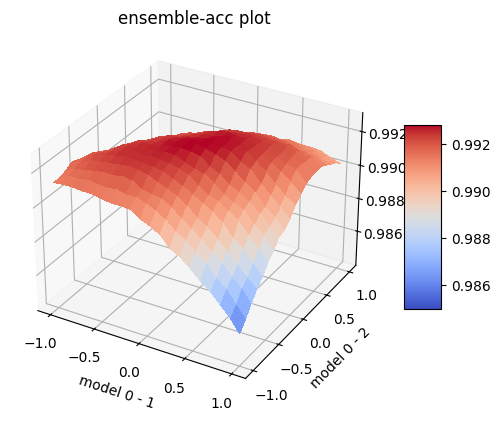

In [6]:
# %matplotlib widget
# import ipympl

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title("ensemble-acc plot", fontsize=12)
ax.set_xlabel('model 0 - 1', fontsize=10)
ax.set_ylabel('model 0 - 2', fontsize=10)
surf = ax.plot_surface(X, Y, Z,cmap=cm.coolwarm, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
model_path_list = ['MickyMike/graphcodebert-c', 'neulab/codebert-cpp', 'neulab/codebert-c']
df_list = []
for model_path in model_path_list:
    model_name = model_path.split('/')[-1]
    df_list.append(pd.read_csv(f'test_{model_name}_logits.csv'))

a = 10
b = 50
c = 40
df = a*df_list[0] + b*df_list[1] + c*df_list[2]
df = np.int8(df['P'] >= df['N'])
index = np.array([f'TEST_{i:06d}' for i in range(len(df))])
df = pd.DataFrame(df.reshape(-1,1), columns=['similar'])
df['pair_id'] = index
df = df.iloc[:,::-1]
df.to_csv(f'submission_ensemble_{a:d}{b:d}{c:d}.csv', index=False)

In [1]:
model_path_list = ['MickyMike/graphcodebert-c', 'neulab/codebert-cpp', 'neulab/codebert-c']
df_list = []
for model_path in model_path_list:
    model_name = model_path.split('/')[-1]
    df_list.append(pd.read_csv(f'test_{model_name}_logits.csv'))

df = np.int8(df_list[0]['P'] >= df_list[0]['N']) + np.int8(df_list[1]['P'] >= df_list[1]['N']) + np.int8(df_list[2]['P'] >= df_list[2]['N'])
df = np.int8(df >= 2)
index = np.array([f'TEST_{i:06d}' for i in range(len(df))])
df = pd.DataFrame(df.reshape(-1,1), columns=['similar'])
df['pair_id'] = index
df = df.iloc[:,::-1]
df.to_csv('submission_ensemble.csv', index=False)

NameError: name 'pd' is not defined